# Trading Strategies powered by Machine Learning - Support Vector Classifier

## Support Vector Classifier with scikit-learn - a Simple Introduction

In [1]:
import sys
sys.path.append('../../')

In [2]:
from util.load_data import *
from config.constants import *
from util.plot_equity import plot_equity_trades
from util.Save_result_return import save_to_csv

In [3]:
import matplotlib.ticker as ticker
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from talib import MA_Type
import talib as ta
from bs4 import BeautifulSoup
import datetime
import json
import numpy as np
import pandas as pd
import requests
import time
import warnings
warnings.simplefilter('ignore')

In [4]:
from backtesting import Strategy

## Getting the Data

In [5]:
XAUUSD = load_data()

In [6]:
XAUUSD['H4'].Close

Time
2007-01-01 00:00:00     635.497
2007-01-01 04:00:00     635.699
2007-01-01 08:00:00     635.993
2007-01-01 12:00:00     636.006
2007-01-01 16:00:00     635.989
                         ...   
2023-03-10 00:00:00    1829.085
2023-03-10 04:00:00    1833.405
2023-03-10 08:00:00    1834.865
2023-03-10 12:00:00    1862.975
2023-03-10 16:00:00    1864.098
Name: Close, Length: 25976, dtype: float64

In [7]:
XAUUSD['H4'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25976 entries, 2007-01-01 00:00:00 to 2023-03-10 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    25976 non-null  float64
 1   High    25976 non-null  float64
 2   Low     25976 non-null  float64
 3   Close   25976 non-null  float64
 4   Volume  25976 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 1.2 MB


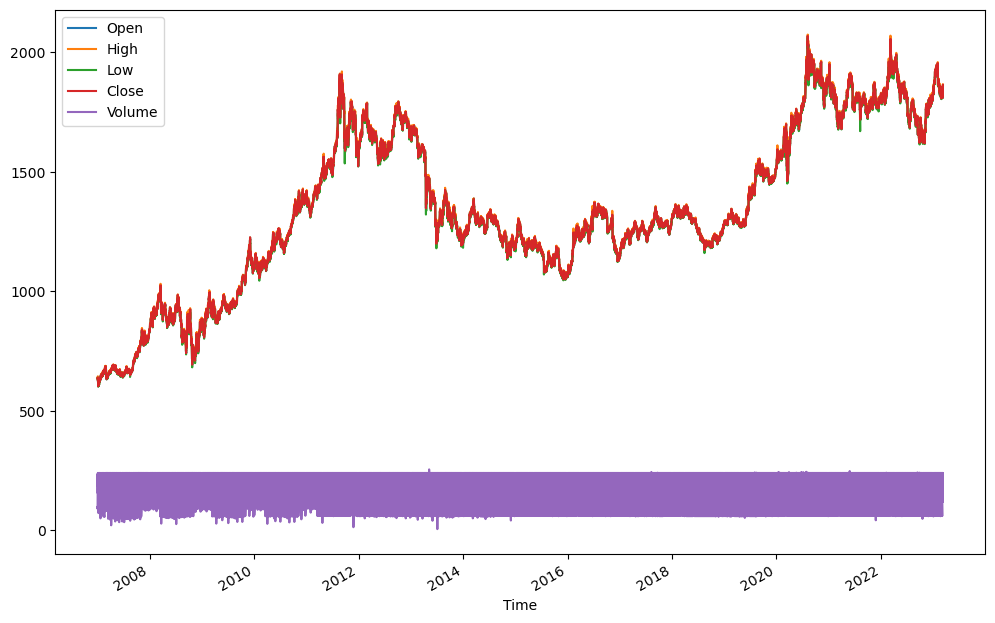

In [8]:
XAUUSD['H4'].plot(figsize = (12, 8))
plt.show()

## ML

### Class and Strategy ML

In [9]:
class Support_Vector_Classifier(Strategy):

    def init(self):
        pass

    def next(self):

        if self.data.pred == 1:
            if not self.position:
                self.buy(size=1)
            elif self.position.is_short:
                self.position.close()
                self.buy(size=1)

        elif self.data.pred == -1:
            if not self.position:
                self.sell(size=1)
            if self.position.is_long:
                self.position.close()
                self.sell(size=1)

        

In [10]:
strategy = Support_Vector_Classifier
account_size = 2000
folder_ML_Strategy = 'Support Vector Classifier'

In [11]:
from backtesting import Backtest
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from util.Save_result_return import save_to_csv
import sys
sys.path.append('../../')


plt.style.use("seaborn-v0_8")


class ML_SVC():

    def __init__(self, data, strategy, start_train, start_test, end_train, end_test, TF):
        self.data = data
        self.strategy = strategy
        self.start_train = start_train
        self.start_test = start_test
        self.end_train = end_train
        self.end_test = end_test
        self.TF = TF
        self.data_train = None
        self.data_test = None
        self.results = None
        self.model = None

    def Create_Features(self):
        data = self.data.copy()

        data['High Shifted'] = data['High'].shift(1)
        data['Low Shifted'] = data['Low'].shift(1)
        data['Close Shifted'] = data['Close'].shift(1)

        data['Upper BBand'], data['Middle BBand'], data['Lower BBand'] = ta.BBANDS(
            data['Close Shifted'], timeperiod=20,)

        data['RSI'] = ta.RSI(np.array(data['Close Shifted']), timeperiod=14)

        data['Macd'], data['Macd Signal'], data['Macd Hist'] = ta.MACD(
            data['Close Shifted'], fastperiod=12, slowperiod=26, signalperiod=9)

        data['Momentum'] = ta.MOM(data['Close Shifted'], timeperiod=12)

        data['Returns'] = np.log(data['Open']/data['Open'].shift(1))

        self.data = data

        return data

    def Add_Signal(self):
        self.data['Signal'] = np.where((self.data['Returns'] > 0), 1, -1)

    def Train_Model(self):
        self.Create_Features()
        self.Add_Signal()

        # Extract data within the specified date range
        self.data_train = self.data.loc[self.start_train:self.end_train].copy()
        self.data_test = self.data.loc[self.start_test:self.end_test].copy()

        # Drop missing values from the training dataset
        self.data_train.dropna(inplace=True)

        # Ensure 'Signal' column exists in data_train
        if 'Signal' not in self.data_train.columns:
            raise ValueError("'Signal' column is missing in data_train")

        # Define features and target columns
        features = ['Upper BBand', 'RSI', 'Macd', 'Momentum']
        target = 'Signal'

        # Prepare data for model training
        X_train = self.data_train[features]
        y_train = self.data_train[target]

        # Normalize/Scale data using MaxAbsScaler
        max_abs_scaler = preprocessing.MaxAbsScaler()
        X_train_scaled = max_abs_scaler.fit_transform(X_train)

        # Instantiate the model (assuming you have imported svm from sklearn)
        self.model = svm.SVC(kernel='rbf', decision_function_shape='ovo')

        try:
            # Fit the model
            self.model.fit(X_train_scaled, y_train)

            # Make predictions on training and test data
            self.data_train['pred'] = self.model.predict(X_train_scaled)
            self.data_test['pred'] = self.model.predict(
                max_abs_scaler.transform(self.data_test[features]))
        except Exception as e:
            print(f"Error occurred during model fitting: {e}")

    def Backtest(self, data, account_size=2000):
        # Assuming you have a Backtest class that performs backtesting
        backtest = Backtest(data, self.strategy,
                            cash=account_size, margin=1 / 2000)
        result = backtest.run()
        return result

    def Run(self):

        self.Train_Model()

        result_train = self.Backtest(self.data_train)

        result_test = self.Backtest(self.data_test)

        return result_train, result_test

In [12]:
ML_Class = ML_SVC

## TF D1

In [13]:
data = XAUUSD['D1']
start_train = '2007'
start_test = '2020'
end_train = '2020'
end_test = '2023'
TF = 'D1'

In [14]:
ml = ML_Class(data,strategy,start_train,start_test,end_train,end_test,TF)

In [15]:
train , test = ml.Run()

### In-Sample Backtesting

In [16]:
train

Start                     2007-02-09 00:00:00
End                       2020-12-31 00:00:00
Duration                   5074 days 00:00:00
Exposure Time [%]                   99.953811
Equity Final [$]                     3467.212
Equity Peak [$]                      3871.214
Return [%]                            73.3606
Buy & Hold Return [%]              184.922748
Return (Ann.) [%]                    3.253928
Volatility (Ann.) [%]                7.957983
Sharpe Ratio                         0.408889
Sortino Ratio                        0.622393
Calmar Ratio                         0.258259
Max. Drawdown [%]                  -12.599465
Avg. Drawdown [%]                   -1.557347
Max. Drawdown Duration      785 days 00:00:00
Avg. Drawdown Duration       46 days 00:00:00
# Trades                                  711
Win Rate [%]                        44.585091
Best Trade [%]                      16.646243
Worst Trade [%]                     -9.384876
Avg. Trade [%]                    

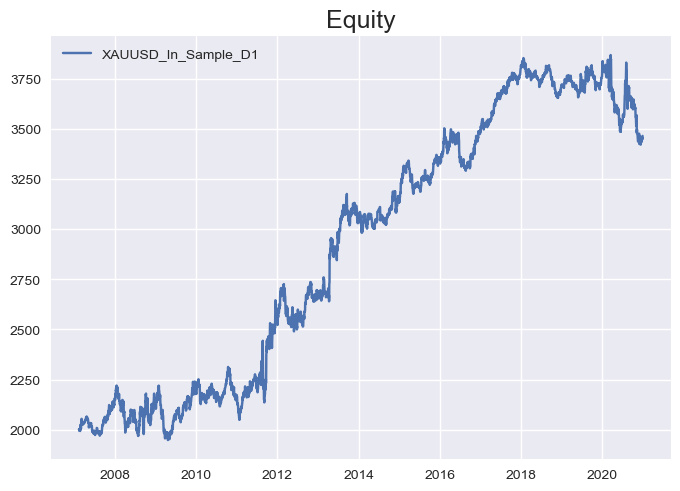

In [17]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [18]:
test

Start                     2020-01-01 00:00:00
End                       2023-03-10 00:00:00
Duration                   1164 days 00:00:00
Exposure Time [%]                   99.798184
Equity Final [$]                     1367.602
Equity Peak [$]                       2096.47
Return [%]                           -31.6199
Buy & Hold Return [%]               22.776554
Return (Ann.) [%]                   -9.212823
Volatility (Ann.) [%]               15.041819
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -39.787977
Avg. Drawdown [%]                  -12.901406
Max. Drawdown Duration     1086 days 00:00:00
Avg. Drawdown Duration      290 days 00:00:00
# Trades                                  178
Win Rate [%]                        38.202247
Best Trade [%]                      10.732681
Worst Trade [%]                     -4.530347
Avg. Trade [%]                    

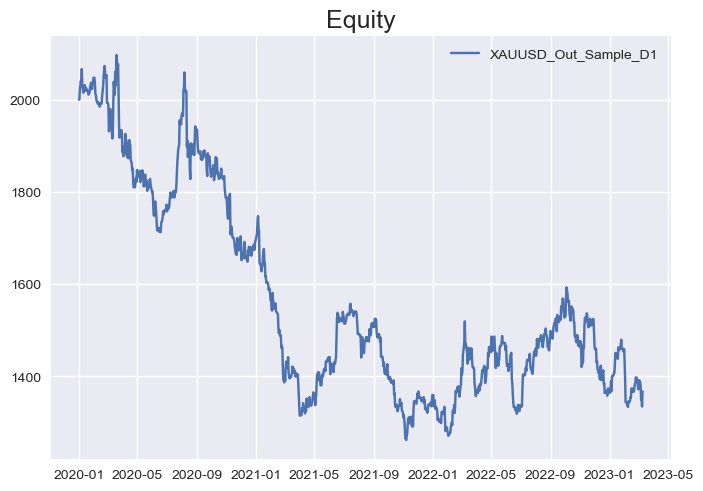

In [19]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [20]:
filename_train = f'result_{TF}_In_Sample.csv'

In [21]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [22]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [23]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF H4

In [24]:
data = XAUUSD['H4']
start_train = '2007'
start_test = '2020'
end_train = '2020'
end_test = '2023'
TF = 'H4'

In [25]:
ml = ML_Class(data,strategy,start_train,start_test,end_train,end_test,TF)

In [26]:
train , test = ml.Run()

### In-Sample Backtesting

In [27]:
train

Start                     2007-01-08 12:00:00
End                       2020-12-31 20:00:00
Duration                   5106 days 08:00:00
Exposure Time [%]                   99.991088
Equity Final [$]                     2957.638
Equity Peak [$]                      2982.868
Return [%]                            47.8819
Buy & Hold Return [%]              211.952823
Return (Ann.) [%]                    2.290841
Volatility (Ann.) [%]                8.466544
Sharpe Ratio                         0.270576
Sortino Ratio                        0.404903
Calmar Ratio                         0.094281
Max. Drawdown [%]                  -24.298092
Avg. Drawdown [%]                   -1.322212
Max. Drawdown Duration     2792 days 08:00:00
Avg. Drawdown Duration       58 days 13:00:00
# Trades                                 4016
Win Rate [%]                        42.579681
Best Trade [%]                       7.222545
Worst Trade [%]                    -12.096569
Avg. Trade [%]                    

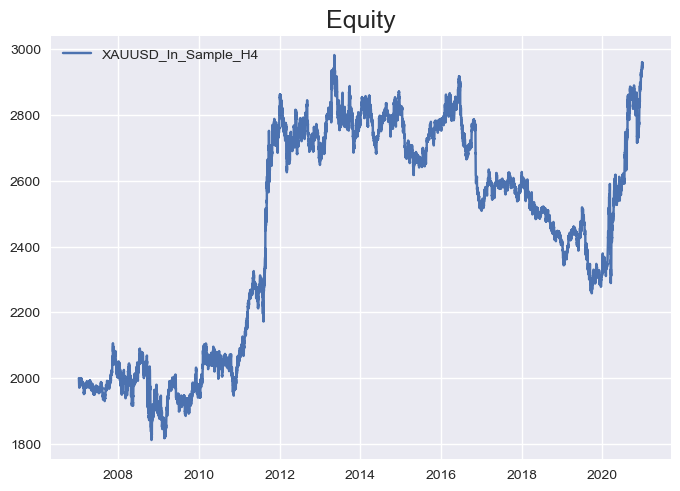

In [28]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [29]:
test

Start                     2020-01-01 20:00:00
End                       2023-03-10 16:00:00
Duration                   1163 days 20:00:00
Exposure Time [%]                   99.960823
Equity Final [$]                     3236.402
Equity Peak [$]                      3372.616
Return [%]                            61.8201
Buy & Hold Return [%]               22.776554
Return (Ann.) [%]                    13.01981
Volatility (Ann.) [%]               11.233222
Sharpe Ratio                         1.159045
Sortino Ratio                        1.984915
Calmar Ratio                         0.980328
Max. Drawdown [%]                  -13.281071
Avg. Drawdown [%]                   -1.084762
Max. Drawdown Duration      129 days 08:00:00
Avg. Drawdown Duration        9 days 22:00:00
# Trades                                 1011
Win Rate [%]                        46.191889
Best Trade [%]                       6.556112
Worst Trade [%]                     -3.989126
Avg. Trade [%]                    

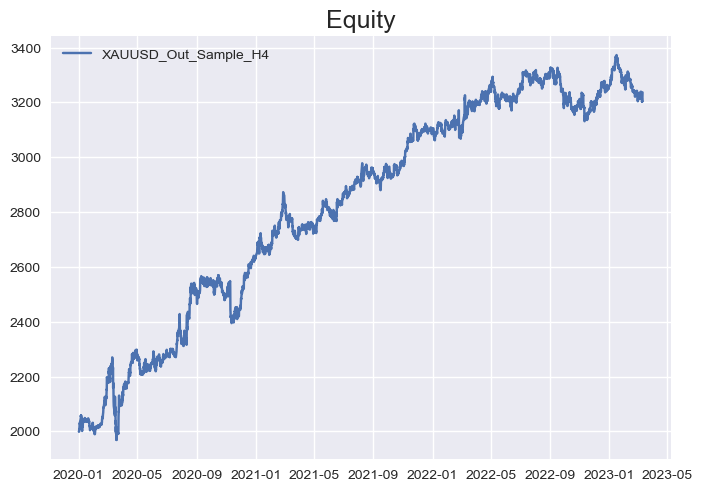

In [30]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [31]:
filename_train = f'result_{TF}_In_Sample.csv'

In [32]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [33]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [34]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF H1

In [35]:
data = XAUUSD['H1']
start_train = '2007'
start_test = '2020'
end_train = '2020'
end_test = '2023'
TF = 'H1'

In [36]:
ml = ML_Class(data,strategy,start_train,start_test,end_train,end_test,TF)

In [37]:
train , test = ml.Run()

### In-Sample Backtesting

In [ ]:
train

Start                     2007-01-02 10:00:00
End                       2020-12-31 21:00:00
Duration                   5112 days 11:00:00
Exposure Time [%]                   99.997647
Equity Final [$]                     2332.755
Equity Peak [$]                      2694.676
Return [%]                           16.63775
Buy & Hold Return [%]              196.474825
Return (Ann.) [%]                    0.893225
Volatility (Ann.) [%]                10.48078
Sharpe Ratio                         0.085225
Sortino Ratio                        0.123292
Calmar Ratio                         0.025021
Max. Drawdown [%]                  -35.699365
Avg. Drawdown [%]                    -0.93034
Max. Drawdown Duration     3905 days 08:00:00
Avg. Drawdown Duration       35 days 00:00:00
# Trades                                16515
Win Rate [%]                        42.755071
Best Trade [%]                        9.80558
Worst Trade [%]                     -5.431913
Avg. Trade [%]                    

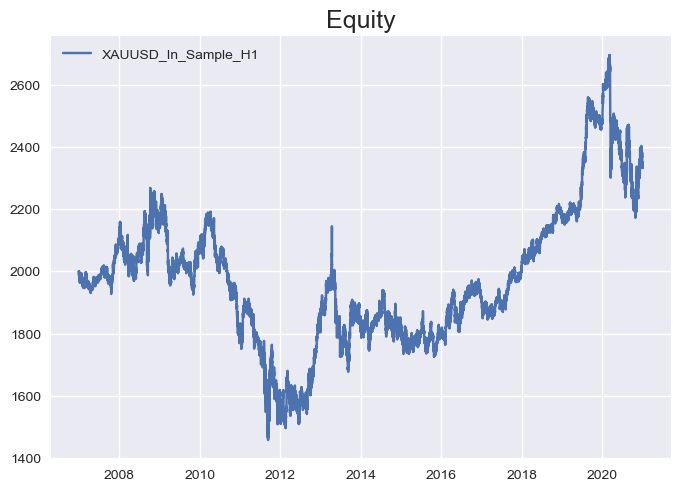

In [ ]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [ ]:
test

Start                     2020-01-01 23:00:00
End                       2023-03-10 17:00:00
Duration                   1163 days 18:00:00
Exposure Time [%]                   99.989397
Equity Final [$]                     1929.418
Equity Peak [$]                      2214.348
Return [%]                            -3.5291
Buy & Hold Return [%]               22.776554
Return (Ann.) [%]                   -0.909467
Volatility (Ann.) [%]               14.879835
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -31.878594
Avg. Drawdown [%]                   -1.203235
Max. Drawdown Duration     1096 days 13:00:00
Avg. Drawdown Duration       28 days 08:00:00
# Trades                                 3784
Win Rate [%]                        42.679704
Best Trade [%]                       6.474645
Worst Trade [%]                     -5.431913
Avg. Trade [%]                    

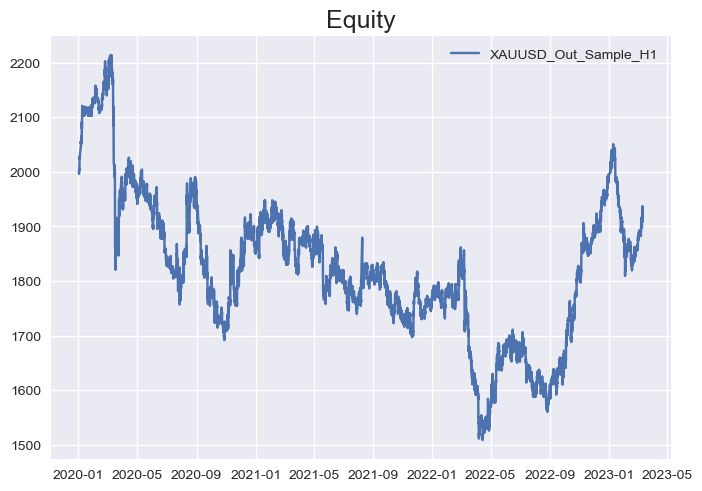

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [ ]:
filename_train = f'result_{TF}_In_Sample.csv'

In [ ]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [ ]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [ ]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M30

In [ ]:
data = XAUUSD['M30']
start_train = '2007'
start_test = '2020'
end_train = '2020'
end_test = '2023'
TF = 'M30'

In [ ]:
ml = ML_Class(data,strategy,start_train,start_test,end_train,end_test,TF)

In [ ]:
train , test = ml.Run()

### In-Sample Backtesting

In [ ]:
train

Start                     2007-01-01 17:00:00
End                       2020-12-31 21:30:00
Duration                   5113 days 04:30:00
Exposure Time [%]                   99.998819
Equity Final [$]                     1293.999
Equity Peak [$]                      2618.048
Return [%]                          -35.30005
Buy & Hold Return [%]              198.451728
Return (Ann.) [%]                   -2.482543
Volatility (Ann.) [%]               21.634872
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -84.463234
Avg. Drawdown [%]                   -0.696792
Max. Drawdown Duration     4427 days 04:30:00
Avg. Drawdown Duration       20 days 22:23:00
# Trades                                33435
Win Rate [%]                        42.114551
Best Trade [%]                       6.008893
Worst Trade [%]                     -4.795604
Avg. Trade [%]                    

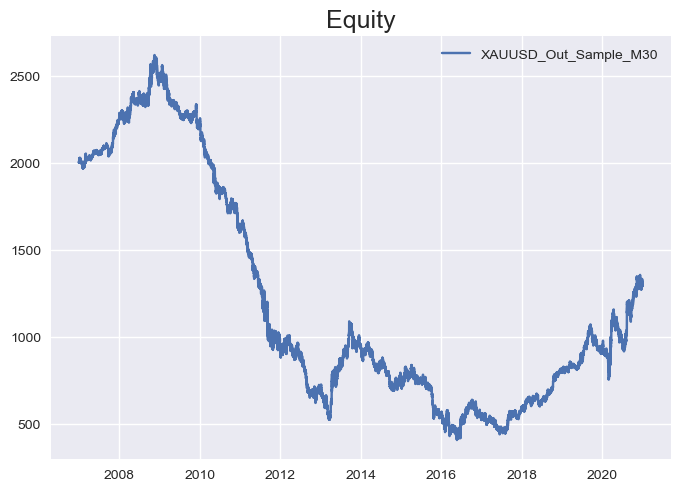

In [ ]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [ ]:
test

Start                     2020-01-01 23:00:00
End                       2023-03-10 17:30:00
Duration                   1163 days 18:30:00
Exposure Time [%]                   99.994697
Equity Final [$]                     2322.525
Equity Peak [$]                      2640.427
Return [%]                           16.12625
Buy & Hold Return [%]               22.670469
Return (Ann.) [%]                    3.875006
Volatility (Ann.) [%]               11.630453
Sharpe Ratio                         0.333178
Sortino Ratio                        0.543006
Calmar Ratio                         0.273661
Max. Drawdown [%]                  -14.159869
Avg. Drawdown [%]                   -0.934479
Max. Drawdown Duration      386 days 00:00:00
Avg. Drawdown Duration        8 days 16:03:00
# Trades                                 7566
Win Rate [%]                        42.479514
Best Trade [%]                        4.60021
Worst Trade [%]                     -4.795604
Avg. Trade [%]                    

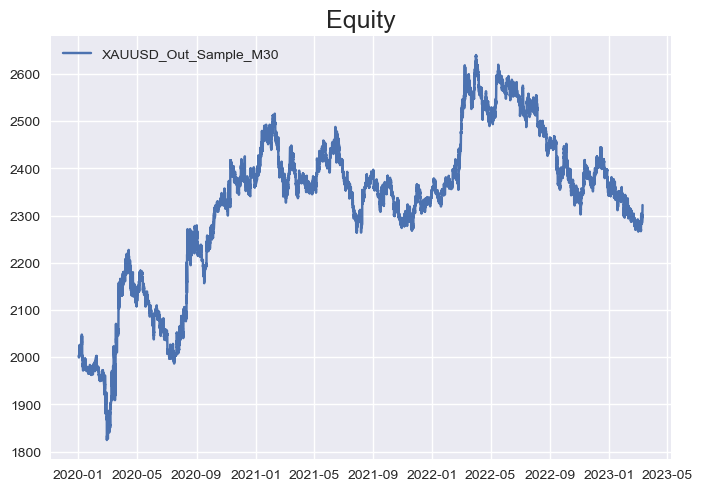

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [ ]:
filename_train = f'result_{TF}_In_Sample.csv'

In [ ]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [ ]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [ ]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M15

In [ ]:
data = XAUUSD['M15']
start_train = '2014'
start_test = '2020'
end_train = '2020'
end_test = '2023'
TF = 'M15'

In [ ]:
ml = ML_Class(data,strategy,start_train,start_test,end_train,end_test,TF)

In [ ]:
train , test = ml.Run()

### In-Sample Backtesting

In [ ]:
train

Start                     2014-09-23 22:15:00
End                       2020-12-31 21:45:00
Duration                   2290 days 23:30:00
Exposure Time [%]                   99.998651
Equity Final [$]                     1717.943
Equity Peak [$]                      2239.161
Return [%]                          -14.10285
Buy & Hold Return [%]               55.186005
Return (Ann.) [%]                   -1.944813
Volatility (Ann.) [%]                9.274792
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -36.179176
Avg. Drawdown [%]                   -0.726674
Max. Drawdown Duration     1484 days 18:15:00
Avg. Drawdown Duration       16 days 05:47:00
# Trades                                29344
Win Rate [%]                        41.950654
Best Trade [%]                       4.818441
Worst Trade [%]                     -2.858887
Avg. Trade [%]                    

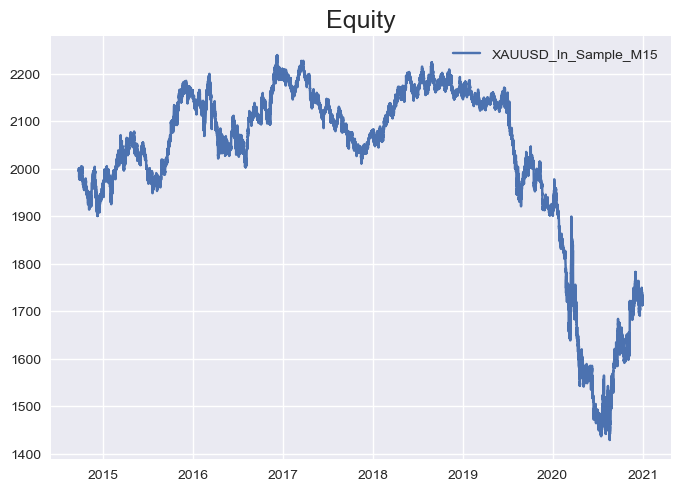

In [ ]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [ ]:
test

Start                     2020-01-01 23:00:00
End                       2023-03-10 17:45:00
Duration                   1163 days 18:45:00
Exposure Time [%]                   99.997348
Equity Final [$]                      1243.51
Equity Peak [$]                      2069.459
Return [%]                           -37.8245
Buy & Hold Return [%]               22.657555
Return (Ann.) [%]                  -11.367763
Volatility (Ann.) [%]               14.995438
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -44.638575
Avg. Drawdown [%]                   -2.235201
Max. Drawdown Duration     1157 days 17:30:00
Avg. Drawdown Duration       52 days 21:21:00
# Trades                                15216
Win Rate [%]                        42.106993
Best Trade [%]                       4.818441
Worst Trade [%]                     -2.858887
Avg. Trade [%]                    

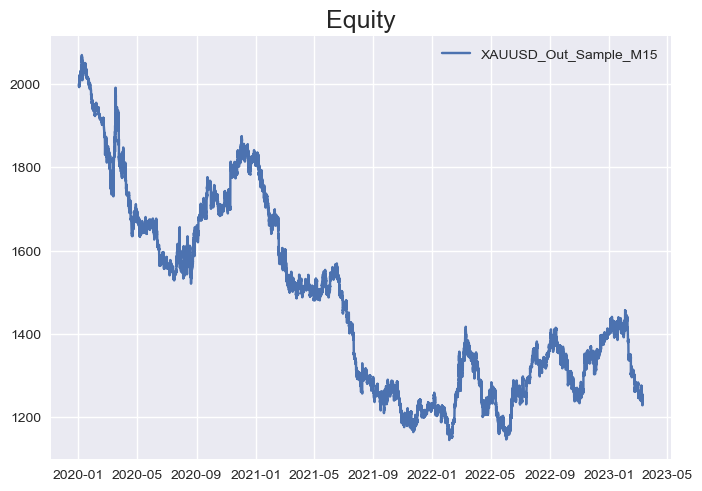

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [ ]:
filename_train = f'result_{TF}_In_Sample.csv'

In [ ]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [ ]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [ ]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M5

In [ ]:
data = XAUUSD['M5']
start_train = '2020'
start_test = '2023'
end_train = '2023'
end_test = '2023'
TF = 'M5'

In [ ]:
ml = ML_Class(data,strategy,start_train,start_test,end_train,end_test,TF)

In [ ]:
train , test = ml.Run()

### In-Sample Backtesting

In [ ]:
train

Start                     2020-05-15 14:00:00
End                       2023-03-10 17:55:00
Duration                   1029 days 03:55:00
Exposure Time [%]                      99.999
Equity Final [$]                      543.219
Equity Peak [$]                        2000.0
Return [%]                          -72.83905
Buy & Hold Return [%]                7.366671
Return (Ann.) [%]                  -31.210314
Volatility (Ann.) [%]               24.514081
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                    -80.3277
Avg. Drawdown [%]                    -80.3277
Max. Drawdown Duration     1029 days 03:50:00
Avg. Drawdown Duration     1029 days 03:50:00
# Trades                                39885
Win Rate [%]                        41.830262
Best Trade [%]                       5.095527
Worst Trade [%]                     -1.632007
Avg. Trade [%]                    

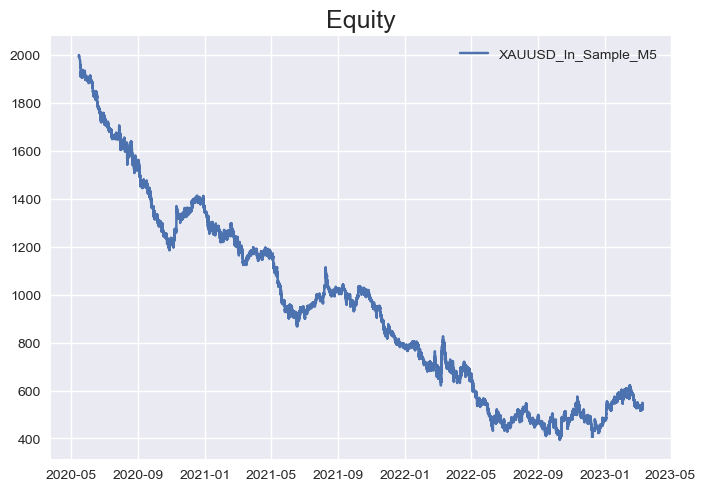

In [ ]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [ ]:
test

Start                     2023-01-02 23:00:00
End                       2023-03-10 17:55:00
Duration                     66 days 18:55:00
Exposure Time [%]                    99.98507
Equity Final [$]                     2058.594
Equity Peak [$]                      2137.104
Return [%]                             2.9297
Buy & Hold Return [%]                2.045231
Return (Ann.) [%]                   15.025836
Volatility (Ann.) [%]               11.974472
Sharpe Ratio                         1.254822
Sortino Ratio                        2.560599
Calmar Ratio                         3.039046
Max. Drawdown [%]                   -4.944261
Avg. Drawdown [%]                   -0.309241
Max. Drawdown Duration       23 days 08:50:00
Avg. Drawdown Duration        0 days 18:08:00
# Trades                                 2676
Win Rate [%]                        42.526158
Best Trade [%]                        2.13473
Worst Trade [%]                     -0.722786
Avg. Trade [%]                    

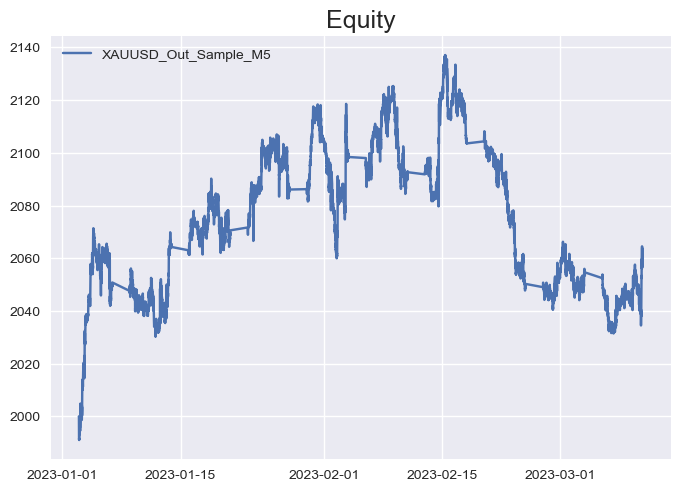

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [ ]:
filename_train = f'result_{TF}_In_Sample.csv'

In [ ]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [ ]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [ ]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M1

In [ ]:
data = XAUUSD['M1']
start_train = '2022'
start_test = '2023'
end_train = '2023'
end_test = '2023'
TF = 'M1'

In [ ]:
ml = ML_Class(data,strategy,start_train,start_test,end_train,end_test,TF)

In [ ]:
train , test = ml.Run()

### In-Sample Backtesting

In [ ]:
train

In [ ]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [ ]:
filename_train = f'result_{TF}_In_Sample.csv'

In [ ]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [ ]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [ ]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')